In [84]:
import os, torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [2]:
main_dir = '/Users/julian/temp/selected_models_for_ESO_presentation'
multiGLM = os.path.join(main_dir, 'all_pCT_logReg')
MTT = os.path.join(main_dir, 'MTT2_logReg')
Tmax = os.path.join(main_dir, 'Tmax0_logReg')
CBF = os.path.join(main_dir, 'CBF1_logReg')
CBV = os.path.join(main_dir, 'CBV3_logReg')

modality_dirs = [multiGLM, MTT, Tmax, CBF, CBV]

In [3]:
def flatten(l):
    if not (type(l[0]) == list or isinstance(l[0], np.ndarray)):
        return l
    return [item for sublist in l for item in sublist]

In [4]:
columns = ['model_name', 'rf', 'model_class', 'model_tag', 'roc_auc', 'dice']

scores_df = pd.DataFrame(columns = columns)

for modality_dir in modality_dirs[:]:
    if os.path.isdir(modality_dir):
        rf_evaluations = [o for o in os.listdir(modality_dir)
                            if os.path.isdir(os.path.join(modality_dir,o))]

        for rf_eval in rf_evaluations:
            print('Reading', rf_eval)
            rf_eval_dir = os.path.join(modality_dir, rf_eval)

            result_files = [i for i in os.listdir(rf_eval_dir)
                                if os.path.isfile(os.path.join(rf_eval_dir, i))
                                    and i.startswith('scores_') and i.endswith('.npy')]
            results = torch.load(os.path.join(rf_eval_dir, result_files[0]))

            params_files = [i for i in os.listdir(rf_eval_dir)
                                if os.path.isfile(os.path.join(rf_eval_dir, i))
                                    and i.startswith('params_') and i.endswith('.npy')]
            params = torch.load(os.path.join(rf_eval_dir, params_files[0]))

            model_name = '_'.join(rf_eval.split('_')[:-1])
            if 'params' in results:
                params = results['params']
            try:
                rf = int(np.median(params['rf']))
            except (KeyError, TypeError):
                rf = int(result_files[0].split('_')[-1].split('.')[0])

            if 'all_pCT' in model_name:
                model_class = 'glm(all channels)'
            if 'Tmax' in model_name:
                model_class = 'glm(Tmax)'
            if 'Tmax0_6' in model_name:
                model_class = 'Tmax > 6s'
            if 'Tmax0_custom' in model_name:
                # this should be the same as glm(Tmax) at rf0
                model_class = 'Tmax > t'
                continue
            if 'continuous_Tmax' in model_name:
                model_class = 'g(Tmax)'
            if 'CBV' in model_name:
                model_class = 'glm(CBV)'
            if 'norm_CBV' in model_name:
                model_class = 'glm(nCBV)'
            if 'CBF' in model_name:
                model_class = 'glm(CBF)'
            if 'norm_CBF' in model_name:
                model_class = 'glm(nCBF)'
            if 'MTT' in model_name:
                model_class = 'glm(MTT)'
            if 'Campbell' in model_name and 'trained' in model_name:
                model_class = 'relCBF < t'
            if 'Campbell' in model_name and not 'trained' in model_name:
                model_class = 'nCBF'

            model_tag = model_class + ' at rf ' + str(rf)

            # leave out other models
            # if not (rf == 0 or rf == 3):
            #     continue
            test_roc_auc = flatten(results['test_roc_auc'])
            test_dice = flatten(results['test_image_wise_dice'])

            new_entries = list(zip(
                np.repeat(model_name,len(test_roc_auc)),
                np.repeat(rf,len(test_roc_auc)),
                np.repeat(model_class,len(test_roc_auc)),
                np.repeat(model_tag,len(test_roc_auc)),
                test_roc_auc,
                test_dice
                ))
            scores_df = scores_df.append(pd.DataFrame(new_entries, columns = columns))

Reading all_pCT_logReg_rf_3_output
Reading srv3_all_pCT_logReg_rf_4_output
Reading run2_all_pCT_logReg_rf_1_output
Reading all_pCT_logReg_rf_0_output
Reading run2_all_pCT_logReg_rf_2_output
Reading MTT2_logReg_rf_5_output
Reading MTT2_logReg_rf_1_output
Reading MTT2_logReg_rf_3_output
Reading MTT2_logReg_rf_4_output
Reading MTT2_logReg_rf_0_output
Reading MTT2_logReg_rf_2_output
Reading Tmax0_logReg_rf_2_output
Reading Tmax0_logReg_rf_0_output
Reading Tmax0_logReg_rf_4_output
Reading Tmax0_logReg_rf_3_output
Reading Tmax0_logReg_rf_1_output
Reading Tmax0_logReg_rf_5_output
Reading CBF1_logReg_rf_0_output
Reading CBF1_logReg_rf_2_output
Reading CBF1_logReg_rf_4_output
Reading CBF1_logReg_rf_1_output
Reading CBF1_logReg_rf_3_output
Reading CBF1_logReg_rf_5_output
Reading CBV3_logReg_rf_5_output
Reading CBV3_logReg_rf_1_output
Reading CBV3_logReg_rf_3_output
Reading CBV3_logReg_rf_4_output
Reading CBV3_logReg_rf_0_output
Reading CBV3_logReg_rf_2_output


In [19]:
mean_df = scores_df[['rf', 'model_class', 'roc_auc']].groupby(['rf', 'model_class'], as_index=False).mean()
mean_df.head()

,rf,model_class,roc_auc
0,0,glm(CBF),0.682085
1,0,glm(CBV),0.631982
2,0,glm(MTT),0.607600
3,0,glm(Tmax),0.782244
4,0,glm(all channels),0.791579


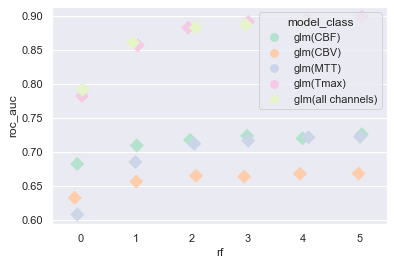

In [38]:
sns.stripplot(x='rf', y='roc_auc', s=10, jitter=True, data=mean_df, hue='model_class',
              edgecolor="white", alpha=1, palette='Pastel2', marker="D")

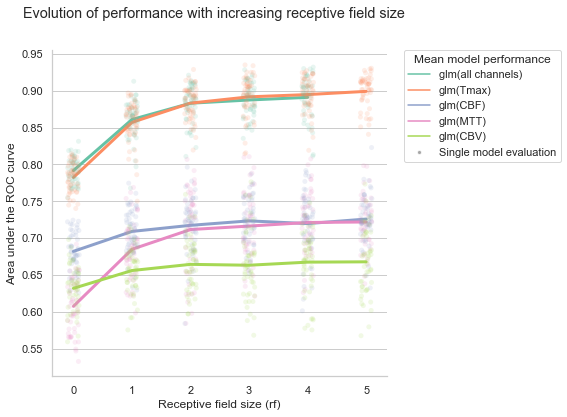

In [101]:
# Draw a combo histogram and scatterplot with density contours
f, ax = plt.subplots(figsize=(6, 6))

palette = 'Set2'
ax = sns.stripplot(x='rf', y='roc_auc', s=5, jitter=True, data=scores_df, hue='model_class',
              edgecolor="gray", alpha=.15, palette=palette, ax=ax, hue_order=['glm(all channels)', 'glm(Tmax)', 'glm(CBF)', 'glm(MTT)', 'glm(CBV)'])
# sns.stripplot(x='rf', y='roc_auc', s=10, jitter=True, data=mean_df, hue='model_class',
#               edgecolor="white", alpha=1, palette='Pastel2', marker="D")
sns.lineplot(x='rf', y='roc_auc', data=mean_df, hue='model_class', lw=3,
              alpha=1, palette=palette, ax=ax, hue_order=['glm(all channels)', 'glm(Tmax)', 'glm(CBF)', 'glm(MTT)', 'glm(CBV)'])
ax.set_label('')
sns.set_style("whitegrid")
sns.despine()

plt.ylabel('Area under the ROC curve')
plt.xlabel('Receptive field size (rf)')
t = plt.suptitle('Evolution of performance with increasing receptive field size')

handles, labels = ax.get_legend_handles_labels()

selected_handels = handles[:5]
selected_labels = labels[:5]

selected_handels.append(Line2D([0], [0], marker='o', color='w', alpha=0.7,
                          markerfacecolor='grey', markersize=4))
selected_labels.append('Single model evaluation')

l = plt.legend(selected_handels, selected_labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fancybox=True,
               title='Mean model performance')
plt.show()


In [102]:
f.savefig(os.path.join(main_dir, "roc_auc_per_rf.svg"), format="svg", bbox_extra_artists=(l,t), bbox_inches='tight')


/Users/julian/opt/anaconda3/envs/stroke-predict/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 39.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/julian/opt/anaconda3/envs/stroke-predict/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 33.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/julian/opt/anaconda3/envs/stroke-predict/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 47.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/julian/opt/anaconda3/envs/stroke-predict/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warn

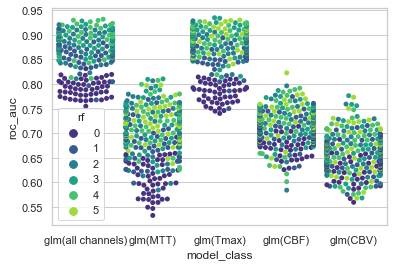

In [6]:
sns.set_theme(style="whitegrid", palette='viridis')


# Draw a categorical scatterplot to show each observation
ax = sns.swarmplot(x="model_class", y="roc_auc", data=scores_df, hue='rf')
